In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To generate GIFs
!pip install imageio
!pip install mtcnn
!pip install git+https://github.com/tensorflow/docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.4 MB/s eta 0:00:00
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-nqxqilh0
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-nqxqilh0
  Resolved https://github.com/tensorflow/docs to commit 9efadf0a84eae76e347787e344626650ea4ed85b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.3.27.3713-py3-none-any.whl size=182447 sha256=0c778cb5d8f912d612d948dc7fe01016d4c33279b5ff9b983a77bd5b8e1ce529
  Stored in directory: /tmp/pip-ephem-wheel-cache-jx64i66b/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import tensorflow_docs.vis.embed as embed
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


import tensorflow as tf
import os
from PIL import Image
import numpy as np
from mtcnn import MTCNN


import random
from PIL import Image, ImageOps, ImageEnhance

# Load the MTCNN face detector
detector = MTCNN()


# fer2013_dir = "FER-2013"
fer2013_dir = "/content/drive/MyDrive/Projects (1)/Facial_Expression_Classification/DK+"
# emotion_mapping = {
#     'angry': 0,
#     'disgust': 1,
#     'fear': 2,
#     'happy': 3,
#     'neutral': 4,
#     'sad': 5,
#     'surprise': 6
# }
emotion_mapping = {
    'anger': 0,
    'contempt': 1,
    'disgust': 2,
    'fear': 3,
    'happiness': 4,
    'neutral': 5,
    'sadness': 6,
    'surprise': 7
}
# Define the desired image size
image_size = (48, 48)

# Function to crop the face area from an image


def crop_face(image):
    # Ensure the image is in RGB
    if image.mode != "RGB":
        image = image.convert("RGB")

    # Detect faces in the image
    faces = detector.detect_faces(np.array(image))

    if faces:
        # Get the bounding box of the first face
        face_box = faces[0]["box"]

        # Calculate the coordinates for cropping
        x, y, w, h = face_box
        cropped_image = image.crop((x, y, x + w, y + h))

        return cropped_image
    else:
        # If no faces are detected, return the original image
        return image


# Function to load images from a directory with face cropping
def load_images_from_directory(directory):
    images = []
    labels = []

    for emotion in os.listdir(directory):
        emotion_dir = os.path.join(directory, emotion)

        for filename in os.listdir(emotion_dir):
            image_path = os.path.join(emotion_dir, filename)

            # Load the image and crop the face
            image = Image.open(image_path)
            cropped_image = crop_face(image)  # Crop the face region

            # Resize the cropped image
            resized_image = cropped_image.resize(image_size)

            # Convert to grayscale and normalize
            grayscale_image = resized_image.convert("L")
            normalized_image = np.array(grayscale_image) / 255.0

            # Store the processed image and its corresponding label
            images.append(normalized_image)
            labels.append(emotion_mapping[emotion])

    return np.array(images), np.array(labels)


# Load train images and labels
train_images, train_labels = load_images_from_directory(
    os.path.join(fer2013_dir))

# # Load test images and labels
# test_images, test_labels = load_images_from_directory(
#     os.path.join(fer2013_dir))

# Reshape the image data
train_images = train_images.reshape((-1, 48, 48, 1))
# test_images = test_images.reshape((-1, 48, 48, 1))

# Normalize pixel values to the range [-1, 1]
train_images = (train_images - 0.5) / 0.5
# test_images = (test_images - 0.5) / 0.5

# Print the shape of train and test data
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
# print("Test images shape:", test_images.shape)
# print("Test labels shape:", test_labels.shape)




Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step
Train images shape: (940, 48, 48, 1)
Train labels shape: (940,)


tf.Tensor([[-0.0014507]], shape=(1, 1), dtype=float32)


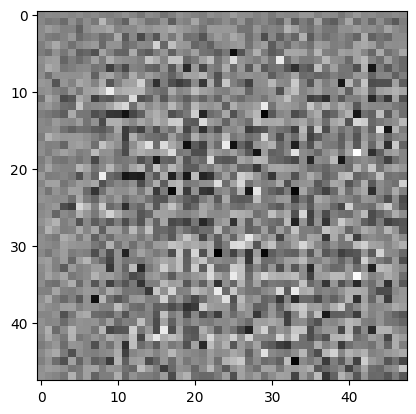

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 8
noise_dim = 100
# Adjust the input shape for FER-2013 dataset
IMG_SHAPE = (48, 48, 1)


# Adjusting batch and shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(
    train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(6*6*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((6, 6, 256)))
    assert model.output_shape == (None, 6, 6, 256)

    model.add(layers.Conv2DTranspose(
        128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(
        64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),
              padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 48, 48, 1)

    return model


generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


# Discriminator Model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2),
              padding='same', input_shape=IMG_SHAPE))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)


# Losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5)  # Lower learning rate
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5)


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


# Training step function with noise initialization
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training function with early stopping


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f"Time for epoch {epoch + 1} is {time.time() - start:.2f} sec")

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()




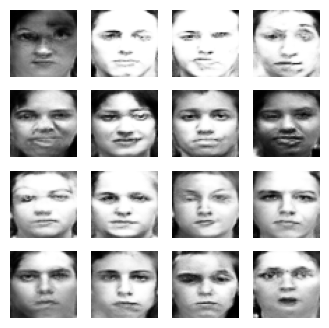

In [ ]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

train(train_dataset, EPOCHS)



In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Display a single image using the epoch number


def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


display_image(EPOCHS)


anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


embed.embed_file(anim_file)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

# Print the shape of the training and testing sets
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Define the input shape and number of classes
input_shape = (48, 48, 1)  # Assuming grayscale images
num_classes = 8

# Create the CNN model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=50, batch_size=32)

# Evaluate the model
test_loss, test_acc = model.evaluate(train_images, train_labels)

# Print the test accuracy
print('Test accuracy:', test_acc)

Train images shape: (752, 48, 48, 1)
Train labels shape: (752,)
Test images shape: (188, 48, 48, 1)
Test labels shape: (188,)
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - 3s 24ms/step - loss: 1.4134 - accuracy: 0.6223
Epoch 2/50
24/24 [==============================] - 0s 6ms/step - loss: 1.2498 - accuracy: 0.6516
Epoch 3/50
24/24 [==============================] - 0s 8ms/step - loss: 1.0082 - accuracy: 0.7141
Epoch 4/50
24/24 [==============================] - 0s 6ms/step - loss: 0.7093 - accuracy: 0.7979
Epoch 5/50
24/24 [==============================] - 0s 6ms/step - loss: 0.5542 - accuracy: 0.8351
Epoch 6/50
24/24 [==============================] - 0s 6ms/step - loss: 0.4345 - accuracy: 0.8670
Epoch 7/50
24/24 [==============================] - 0s 7ms/step - loss: 0.3435 - accuracy: 0.8923
Epoch 8/50
24/24 [==============================] - 0s 7ms/step - loss: 0.3147 - accuracy: 0.9043
Epoch 9/50
24/24 [==============================] - 0s 5ms/step - loss: 0.2174 - accuracy: 0.9309
Epoch 10/50
24/24 [==============================] - 0s 4ms/step - loss: 0.1895 - accuracy: 0.9428
Epoch 11/50
24/24 [==========

6/6 [==============================] - 0s 39ms/step


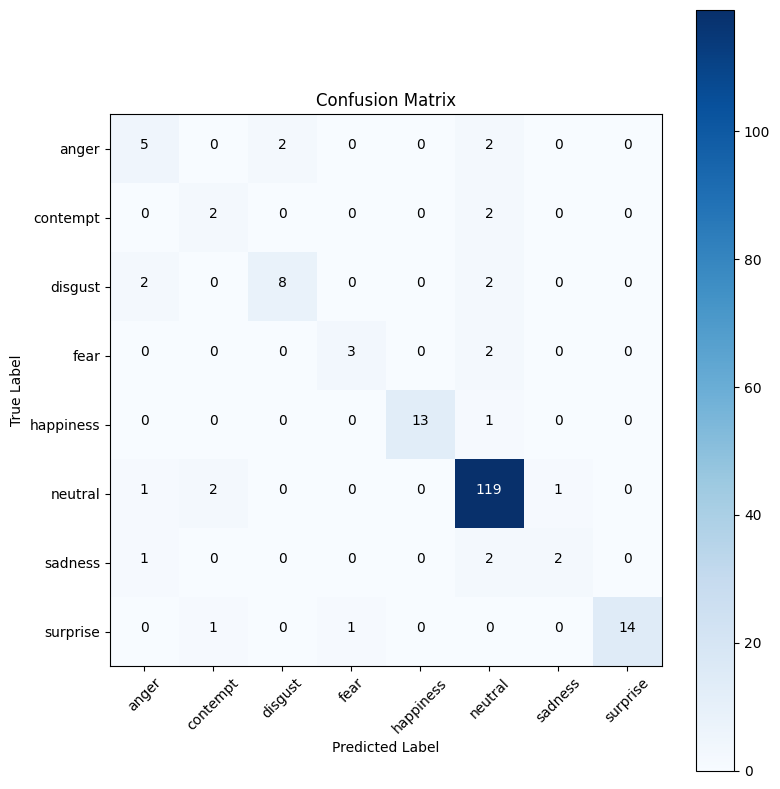

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# Get the predicted probabilities for the test images
predicted_probabilities = model.predict(test_images)

# Convert probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Define the class labels
class_labels = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Add text annotations to the confusion matrix cells
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

1/1 [==============================] - 0s 20ms/step


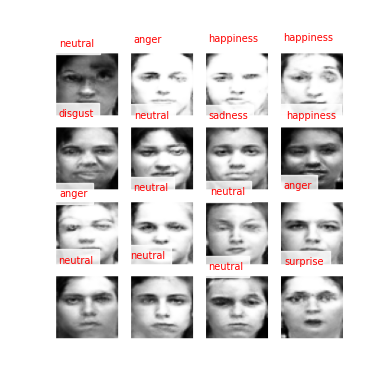

In [ ]:
import matplotlib.pyplot as plt

# Function to predict expressions for multiple faces
def predict_expressions(image_path):
    # Load the input image
    image = Image.open(image_path)
    image = image.convert("RGB")

    # Detect faces in the image using MTCNN
    faces = detector.detect_faces(np.array(image))

    if len(faces) > 0:
        # Iterate over the detected faces
        for face in faces:
            # Get the bounding box of the face
            face_box = face["box"]

            # Crop the face region from the image
            x, y, w, h = face_box
            cropped_image = image.crop((x, y, x + w, y + h))

            # Preprocess the cropped image
            input_image = preprocess_image(cropped_image)

            # Predict the expression using the VGGNet model
            predictions = model.predict(input_image)

            # Get the predicted expression label
            predicted_label = np.argmax(predictions[0])

            # Map the predicted label to the corresponding expression
            expression_mapping = {
                0: 'anger',
                1: 'contempt',
                2: 'disgust',
                3: 'fear',
                4: 'happiness',
                5: 'neutral',
                6: 'sadness',
                7: 'surprise'
            }
            predicted_expression = expression_mapping[predicted_label]

            # Plot the image and display the predicted expression
            plt.imshow(image)
            plt.axis('off')
            plt.text(x, y - 10, predicted_expression, color='red', fontsize=7,
                     bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))

        plt.show()

    else:
        print("No faces detected in the image.")

# Provide the path to the input image
image_path = '/content/image_at_epoch_0150.png'

# Predict expressions for multiple faces in the input image
predict_expressions(image_path)